## 3. LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 3.1. Preprocesamiento de los datos

Realizamos el mismo preprocesamiento de datos para convertir la tabla al formato de fechas ("ds") y ventas ("y").

In [31]:
df_Kern_train = pd.read_csv('Kern_train.csv')
df_Kern_test = pd.read_csv('Kern_test.csv')

In [32]:
#Se cambia la fecha, ya que por defecto ponía día 1 del mes, pero realmente hace referencia a las ventas totales de el mes en cuestión
df_Kern_train['Fecha'] = pd.to_datetime(df_Kern_train['Fecha']).dt.to_period('M').dt.to_timestamp('M')
df_Kern_train.head()

,Código,Denominacion,Ventas,Fecha,Año
0,658257,PARACETAMOL KERN 1GRX40 CO EFG,29,2020-01-31,2020
1,958413,DIAZEPAN PRODES 5 MG 30 COMP,20,2020-01-31,2020
2,658256,PARACETAMOL KERN 1GRX20 CO EFG,30,2020-01-31,2020
3,687626,PARACETAMOL KERN PHARMA 500 MG 20 C EFG,15,2020-01-31,2020
4,673058,SULPIRIDA KERN PHARMA 50 MG 30 CAPS EFG,10,2020-01-31,2020


In [33]:
df_LSTM_total = df_Kern_train.groupby("Fecha")["Ventas"].sum().reset_index()
df_LSTM_total.columns = ['ds', 'y']
df_LSTM_total.head()

,ds,y
0,2020-01-31,886
1,2020-02-29,880
2,2020-03-31,845
3,2020-04-30,844
4,2020-05-31,846


* Escalado de los datos

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(df_LSTM_total[['y']])

### 3.2. Modelo 1.a

Se crea un primer modelo capaz de predecir a partir de la primera ventana de tiempo, es decir, enero de 2021. Una vez obtenido los resultados se comparan con los datos reales.

* Creamos ventanas de tiempo de 12 meses

In [39]:
import numpy as np

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(y_scaled, window_size)

print(X.shape, y.shape)

(36, 12, 1) (36, 1)


En primer lugar, se diseña un modelo secuencial con una capa LSTM de 50 neuronas, una función de activación "Relu", ventanas de tiempo de 12 meses y una capa de salida Dense con una neurona encargada de predecir las ventas del mes siguiente. Posteriormente se compila con el optimizador "Adam", el error cuadrático medio y 100 épocas.

Este modelo predice cada una de las ventas mensuales de los datos disponibles a partir de la primera ventana de tiempos, es decir, los primeros 12 meses.

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_a = Sequential()
model_a.add(LSTM(72, activation='relu', input_shape=(X.shape[1], 1)))
model_a.add(Dense(1))  # Capa de salida

model_a.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


* Se entrena el modelo

In [41]:
resultados = model_a.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3089
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2634
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2243
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1933
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1635
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1304 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0985 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0709
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0602
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0519
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0586
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0673 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0667
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0640
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0545
Epoch 16/200
2/2

* Se predice y se desescalan los resultados

In [42]:
y_pred_a = model_a.predict(X)
y_pred_a_rescaled = scaler.inverse_transform(y_pred_a)
y_real_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


* Gráfica de los resultados

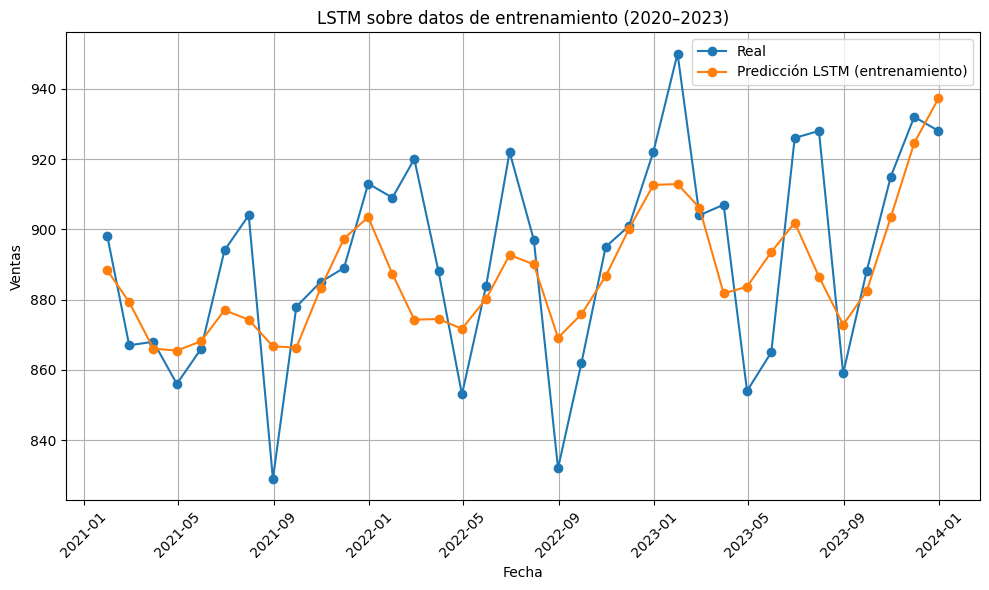

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

fechas_train = df_LSTM_total['ds'][12:].reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(fechas_train, y_real_rescaled, label='Real', marker='o')
plt.plot(fechas_train, y_pred_a_rescaled, label='Predicción LSTM (entrenamiento)', marker='o')
plt.title('LSTM sobre datos de entrenamiento (2020–2023)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Evaluación del modelo

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_real_rescaled, y_pred_a_rescaled)
rmse = np.sqrt(mean_squared_error(y_real_rescaled, y_pred_a_rescaled))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 16.57, RMSE: 20.75


* Conclusión

Los resultados obtenidos reflejan una clara generalización del modelo. A pesar de que las métricas muestran resultados aceptables, el modelo no es capaz de reconocer algunos de los patrones más complejos debido al underfiting.
Por ello, se va a intentar modificar algunos parámetros como el número de capas y neuronas del modelo, el número de épocas en el entrenamiento del modelo y el tamaño de ventana.

### 3.2. Modelo 1.b

En esta ocasión se entrena el modelo con un tamaño de ventana de 24 meses, más capas, mayor cantidad de neuronas y mas épocas.

In [12]:
window_size = 24
X, y = create_sequences(y_scaled, window_size)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_b = Sequential()
model_b.add(LSTM(72, activation='relu', return_sequences=True, input_shape=(X.shape[1], 1)))
model_b.add(LSTM(36, activation='relu', return_sequences=True))
model_b.add(LSTM(12, activation='relu'))  # Última capa no necesita return_sequences
model_b.add(Dense(1))  # Capa de salida

model_b.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
resultados = model_b.fit(X, y, epochs=500, verbose=1)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.3794
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.3661
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.3540
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.3427
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.3274
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.3097
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2909
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2716
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2517
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2305
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2078
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1834
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1571
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1290
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1005
Epoch 16/500
1/1

In [24]:
y_pred_b = model_b.predict(X)
y_pred_b_rescaled = scaler.inverse_transform(y_pred_b)
y_real_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


* Gráfica de los resultados

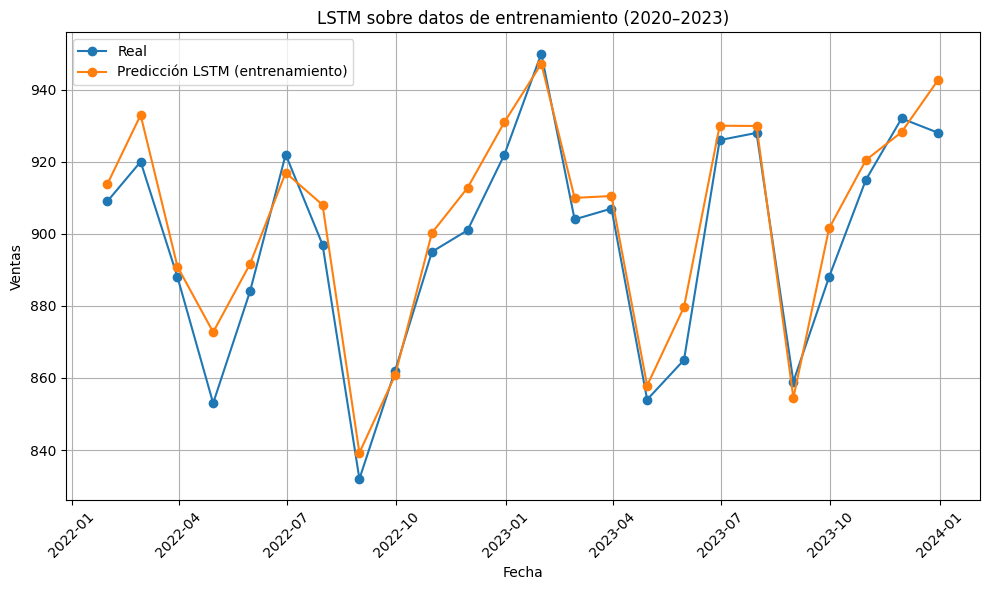

In [25]:
fechas_train = df_LSTM_total['ds'][24:].reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(fechas_train, y_real_rescaled, label='Real', marker='o')
plt.plot(fechas_train, y_pred_b_rescaled, label='Predicción LSTM (entrenamiento)', marker='o')
plt.title('LSTM sobre datos de entrenamiento (2020–2023)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Evaluación del modelo

In [26]:
mae = mean_absolute_error(y_real_rescaled, y_pred_b_rescaled)
rmse = np.sqrt(mean_squared_error(y_real_rescaled, y_pred_b_rescaled))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 7.39, RMSE: 8.82


* Conclusión

En esta ocasión, se ha notado una clara mejora tanto en el reconocimiento de los patrones como en la disminución de los errores. En la gráfica se observa un ajuste más que sobresaliente, y al comparar los errores absolutos y cuadrático medio podemos ver una reducción de ambos a menos de la mitad.
* **Modelo A**  -  **MAE**: 16.57, **RMSE**: 20.75
* **Modelo B**  -  **MAE**: 7.39, **RMSE**: 8.82


### 3.3. Modelo 2.a

En segundo lugar, se va a crear un modelo de predicciones autoregresivas, en el que el modelo se sobrealimenta con la primera predicción para incluirla en la nueva ventana de tiempo, de tal forma que se puedan predecir los próximos 12 meses de los que no se disponen datos.

Para ello, se utilizará la versión del modelo que obtuvo los mejores resultados, el modelo B.

In [27]:
window_size = 24
n_future = 12  # Número de meses a predecir
predictions_scaled = []

# Tomamos la última secuencia completa conocida (los últimos 24 pasos)
last_sequence = y_scaled[-window_size:].reshape(1, window_size, 1)

for _ in range(n_future):
    # Predecir el siguiente valor
    pred = model_b.predict(last_sequence, verbose=0)
    predictions_scaled.append(pred[0, 0])

    # Añadir la predicción a la secuencia y eliminar el primer valor
    last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)

# Desescalar los resultados
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

# Mostrar predicciones
for i, pred in enumerate(predictions, 1):
    print(f"Mes {i}: {pred[0]:.2f} unidades")

Mes 1: 939.56 unidades
Mes 2: 947.62 unidades
Mes 3: 931.45 unidades
Mes 4: 840.60 unidades
Mes 5: 931.00 unidades
Mes 6: 942.55 unidades
Mes 7: 920.90 unidades
Mes 8: 884.97 unidades
Mes 9: 840.39 unidades
Mes 10: 934.12 unidades
Mes 11: 942.49 unidades
Mes 12: 946.34 unidades


* Se preparan los datos de test para la evaluación

In [34]:
df_Kern_test['Fecha'] = pd.to_datetime(df_Kern_test['Fecha']).dt.to_period('M').dt.to_timestamp('M')
df_Kern_test = df_Kern_test.groupby("Fecha")["Ventas"].sum().reset_index()
df_Kern_test.columns = ['ds', 'y']

* Gráfica de los resultados

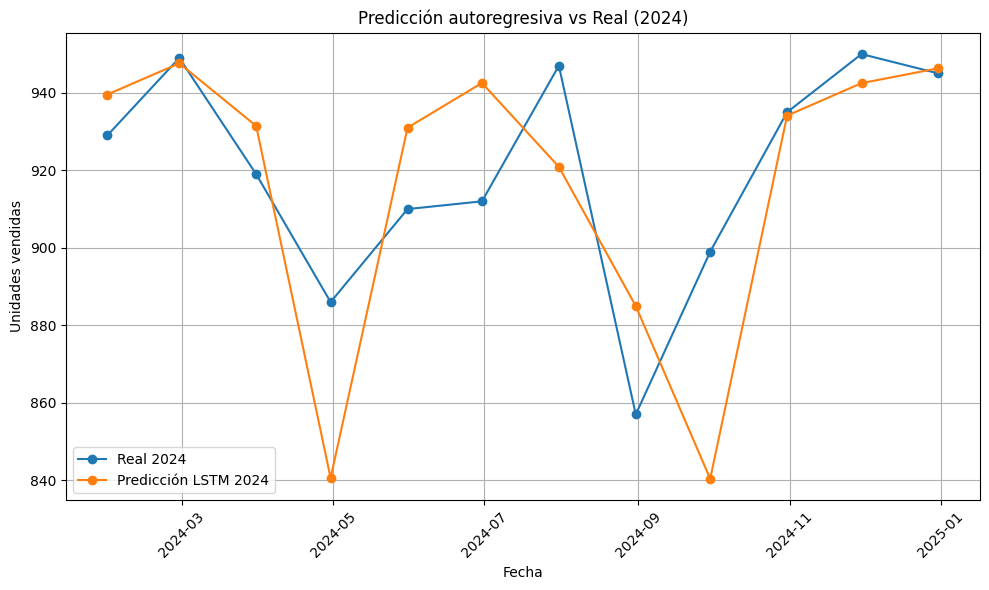

In [35]:
# Asegúrate de que predictions y df_test['y'] tienen la misma forma
plt.figure(figsize=(10, 6))
plt.plot(df_Kern_test['ds'], df_Kern_test['y'], label='Real 2024', marker='o')
plt.plot(df_Kern_test['ds'], predictions, label='Predicción LSTM 2024', marker='o')

plt.title('Predicción autoregresiva vs Real (2024)')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Evaluación del modelo

In [30]:
mae = mean_absolute_error(df_Kern_test['y'], predictions)
rmse = np.sqrt(mean_squared_error(df_Kern_test['y'], predictions))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 20.31, RMSE: 26.87


* Conclusión

A pesar de utilizar las predicciones de los primeros meses para predecir los siguientes, los resultados son más que aceptables. Existe la posibilidad de arrastrar un error y que crezca exponencialmente, pero observando las métricas no parece que este sea el caso.

No obstante, como era de esperar, resulta mucho más preciso el anterior modelo, en el que únicamente predecimos el siguiente mes en base a los datos reales de los últimos 24 meses.


El **Modelo 2.a** presenta una capacidad más que aceptable para predecir las ventas de todo un año. No obstante, será mucho más preciso utilizar el **Modelo 1.b** para predecir únicamente las ventas del próximo mes.


En definitiva, comparando los resultados del **Modelo 1.b** (**MAE**: 7.39, **RMSE**: 8.82) con el **Modelo de Prophet** (**MAE**: 16.92 y **RMSE**: 18.16), se puede confirmar que la primera opción presenta mejores resultados y mejor capacidad para predecir las ventas de la Farmacia. Así, será este el modelo utilizado para gestionar las compras de los laboratorios y el inventario de la farmacia con un mes de antelación. Sin embargo, cuando se pretenda predecir las ventas del próximo año, o con un mayor margen de tiempo, será el **Modelo Prophet** el utilizado, ya que presenta mejor comportamiento que el **Modelo 2.a** (**MAE**: 20.31, **RMSE**: 26.87).